## Import necessary libraries

In [343]:
%reset -f

import pandas as pd
import numpy
import time
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import pandas as pd
import numpy
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import time
import pandas as pd
import os.path
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2 
from sklearn.metrics import mean_squared_log_error
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image, display
import tensorflow
os.environ['PATH'] += ';C:\\Program Files\\Graphviz\\bin'
import graphviz
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor


# !pip install talos
import talos


def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Save environment parameters, so those won't be saved to report file

In [344]:
environment_variables = dir()

## Define model related constants

In [345]:
# Input parameters
# Input parameters
TRAINING_FILES = ["../data/original/training_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_training_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_training_dataset.csv"]
EVALUATION_FILES = ["../data/original/evaluation_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_evaluation_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv"]

FILE_N = 0
INPUT_TRAINING_FILE = TRAINING_FILES[FILE_N] # "../data/original/training_dataset.csv"
INPUT_EVALUATION_FILE = EVALUATION_FILES[FILE_N] # "../data/original/evaluation_dataset.csv"


# Output parameters
METHOD_NAME = "keras_tensorflow_resnet"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL_FOLDER = f"../data/models/keras_models"
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"
OUTPUT_MODEL_ARCHITECTURE_RESULTS = f"../img/{METHOD_NAME}_model_{TIMESTAMP}.png"

# Hyper parameter alternatives
# Bankrupt companies must have higher weight, because there are fewer samples

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 5

# Cross validation parameters
CROSS_VALIDATION_CV = 5

# Cost parameters
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION = 100

# Other constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

# Hyper parameter alternatives
HYPER_PARAMETER_K_FEATURES = list(range(30, 90, 10))
HYPER_PARAMETER_SCORE_FUNC = [chi2, f_classif]
HYPER_PARAMETER_HIDDEN_LAYER_SIZES = [(100,)]
#HYPER_PARAMETER_HIDDEN_LAYER_SIZES = [(100,), (100, 100), (100, 100, 100),
#    (200,), (200, 200), (200, 200, 200), (100, 500)]
HYPER_PARAMETER_ALPHA = list(10.0 ** -numpy.arange(1, 7))

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_BETA = 2
HYPER_PARAMETER_OPTIMIZATION_CV = 5


## Load the datasets
These dataset should contain "Bankrupt?" label and features that should be considered during learning.

In [346]:

training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
training_features = training_dataset.loc[:, training_dataset.columns != "Bankrupt?"]
training_targets = training_dataset["Bankrupt?"]

evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
evaluation_features = evaluation_dataset.loc[:, evaluation_dataset.columns != "Bankrupt?"]
evaluation_targets = evaluation_dataset["Bankrupt?"]

## Define the training pipeline

In [347]:
# # Create internal pipeline
# classifier = svm.SVC(class_weight=HYPER_PARAMETER_CLASS_WEIGHT, random_state=RANDOM_SEED)
# pipeline = Pipeline(steps=[("classification", classifier)])

# # Specify the tunable hyper parameters
# parameters = {
#     "classification__kernel": HYPER_PARAMETER_KERNEL,
#     "classification__gamma": HYPER_PARAMETER_GAMMA
# }

# # Define KFold parameters
# cv = StratifiedKFold(n_splits=HYPER_PARAMETER_OPTIMIZATION_CV, shuffle=True, random_state=42)

# estimator = GridSearchCV(pipeline, parameters,
#     scoring=HYPER_PARAMETER_OPTIMIZATION_SCORING, cv=cv)

In [348]:

def keras_model_for_sklearn(optimizer='adam',#'adagrad',
                    loss = 'binary_crossentropy', 
                    kernel_initializer='glorot_uniform', 
                    dropout=0.2, n_in = 95,
                    n_activator = 'relu',
                    neurons = 213 ,
                    n_out = 2,
                    f_activator = 'softmax',
                    batch_norm = False,
                    metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]
                  ):
        
    
    # def ResNet2(n_in, n_out, neurons = 213 , n_activator = 'relu', f_activator = 'softmax'):
    # def train_fit_model(data_train,target_train, data_test,target_test, model, loss, optimizer, metrics, epochs = 250):

    input =tensorflow.keras.layers.Input(shape=(n_in,))

    output1 =tensorflow.keras.layers.Dense(n_in, input_shape=(n_in,), activation=n_activator)(input)
    if batch_norm:
        output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name='dense_relu' + '2a')(output1)
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)

    dense_name_base = "dense"
    bn_name_base = "dense_additionall"
    shortcut1 =tensorflow.keras.layers.Dense(n_in, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '1')(output1)
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)

    output1 =tensorflow.keras.layers.add([output1, shortcut1])#

        
    output2 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2a')(output1)
    output2 =tensorflow.keras.layers.Dropout(dropout)(output2)
    
    if batch_norm:
        output2 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2a')(output2)
    shortcut2 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2')(output2)
    
    output2 =tensorflow.keras.layers.Dropout(dropout)(output2)
    shortcut1 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '22')(output1)
    
    output2 =tensorflow.keras.layers.Dropout(dropout)(output2)
    output =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='fc1000')(output2)
    
    # Final model
    model =tensorflow.keras.models.Model(inputs=input, outputs=output)
    


    # Plot model information
    plot_= True
    plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
    if plot_:
        plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [349]:
import os

from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.externals import joblib


# Load data
X_train = pd.read_csv(TRAINING_FILES[FILE_N])
y_train = pd.read_csv(EVALUATION_FILES[FILE_N])['Bankrupt?']

# Use Tenserflow backend
sess = tf.Session()
K.set_session(sess)


def model():
    model = models.Sequential([
        layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model


early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')

pipe = pipeline.Pipeline([
    ('rescale', preprocessing.StandardScaler()),
    ('nn', KerasClassifier(build_fn=model, nb_epoch=10, batch_size=128,
                           validation_split=0.2, callbacks=[early_stopping]))
])


pipe.fit(X_train.values, y_train.values)

directory = os.path.dirname(os.path.realpath(__file__))
model_step = pipe.steps.pop(-1)[1]
joblib.dump(pipe, os.path.join(directory, 'pipeline.pkl'))
models.save_model(model_step.model, os.path.join(directory, 'model.h5'))

ImportError: cannot import name 'joblib' from 'sklearn.externals' (c:\UNI\Jupyter\envs\tf\lib\site-packages\sklearn\externals\__init__.py)

35/35 [==============================] - 2s 14ms/step - loss: 0.2948 - accuracy: 0.9109 - val_loss: 1.0330 - val_accuracy: 0.8387
Balanced training. acc: 0.5
Balanced eval. acc: 0.5


## Do training

In [ ]:
def train_fit_model(data_train,target_train, data_test,target_test, model, loss, optimizer, metrics, epochs = 250):

    # Plot model information
    plot_= True
    plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
    if plot_:
        plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    file_path = TIMESTAMP
    file_path = OUTPUT_MODEL_FOLDER + "/" + file_path
    if not os.path.exists(file_path):#os.path.join(OUTPUT_MODEL_FOLDER,file_path)):
        os.makedirs(file_path)
    
    checkpath = file_path
    os.makedirs(checkpath, exist_ok=True)
    checkpath = os.path.join(checkpath, METHOD_NAME + 'model-epoch{epoch:03d}-valloss{val_loss:03f}-acc{val_accuracy:03f}.h5')
    
    stopper = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, mode='auto')
    saver = ModelCheckpoint(checkpath, save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    tensorflow.convert_to_tensor(data_train)
    tensorflow.convert_to_tensor(data_test)

    history = model.fit(data_train, target_train,
                      batch_size=64,
                      epochs=epochs,
                      verbose=2,
                      validation_data=((data_test), target_test),
                    #   callbacks=[saver, stopper])
                    )
                      

    
    return model, history


def simple_dense_model(n_in, n_out, neurons = 213 , n_activator = 'relu', f_activator = 'softmax', droput_val = 0, bn = False):
    inputs =tensorflow.keras.layers.Input(shape=(n_in,), dtype='float32', name='input_layer')  # Input (2 dimensions)

    outputs =tensorflow.keras.layers.Dense(n_in, activation=n_activator, name='hidden_layer_dense2')(inputs)  # Hidden layer
    if bn:
        outputs = tensorflow.keras.layers.BatchNormalization()(outputs)
    outputs =tensorflow.keras.layers.Dropout(droput_val)(outputs)
        
    outputs =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='output_layer')(outputs)  # Output layer (3 labels)

    model =tensorflow.keras.models.Model(inputs=inputs, outputs=outputs, name='neural_network')
    return model

loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]

# Build a model architecture
target_train = np.asarray(training_targets).astype('float32').reshape((-1,1))
target_test = np.asarray(evaluation_targets).astype('float32').reshape((-1,1))#
input_n = len(training_features.columns)

# Preparing the results input/output, for evaluation later on
oh_enc = OneHotEncoder(sparse=False)
target_train_OH = oh_enc.fit_transform(target_train)
target_test_OH = oh_enc.transform(target_test)

# Setting our model main parameters
# model = ResNet2(input_n
#                         , 2
#                         , neurons = input_n 
#                         , n_activator = 'relu'
#                         , f_activator = 'sigmoid'
#                         # , droput_val = 0
#                         # , bn = True)
# )




from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(95,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model
#######################

clf = KerasRegressor(build_fn=create_model,verbose=2)




In [ ]:
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import MultiLabelBinarizer

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(95,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(95//2,activation='relu',kernel_initializer=kernel_initializer))


    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model
#######################

clf = KerasRegressor(build_fn=create_model,verbose=1, epochs = 100, batch_size = 50)

# pipe = make_pipeline(clf)

# pipe.fit(training_features,training_targets)
# print(f'\nScored percentage: {pipe.score(training_features,training_targets)}')

# predicted = pipe.predict(evaluation_features)
# corr_label = np.argmax(evaluation_targets, axis=1)
# n_corr = np.sum(predicted == corr_label)
# print(n_corr)
# print(f'Correct percentage: {n_corr/len(training_targets)}')



from sklearn.model_selection import KFold

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

estimator = KerasClassifier(
  build_fn=create_model, epochs=5, batch_size=5, verbose=2)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(estimator, training_features,training_targets, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



####################################
# Create internal pipeline
classifier = clf# MLPClassifier(solver="lbfgs")
standard_scaler =  StandardScaler()
min_max_scaler =  MinMaxScaler()
feature_selection = SelectKBest()
# pca = PCA(random_state=RANDOM_SEED)
smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_SEED)

pipeline = imbpipeline(steps=[
    ("standard_scaler", standard_scaler),
    # ("min_max_scaler", min_max_scaler),
    # ("selection", feature_selection),
    #  ("smote", smote),
      ("clf", classifier)])

# Specify the tunable hyper parameters
parameters = {
    # "selection__k": HYPER_PARAMETER_K_FEATURES,
    # "selection__score_func": HYPER_PARAMETER_SCORE_FUNC,
    # 'clf__optimizer':['rmsprop','adam','adagrad'],
    'clf__epochs':[4],
    'clf__dropout':[0],#,0.1,0.2],
    # 'clf__kernel_initializer':['glorot_uniform','normal','uniform']
}

# Define KFold parameters
cv = StratifiedKFold(n_splits=HYPER_PARAMETER_OPTIMIZATION_CV, shuffle=True, random_state=RANDOM_SEED)

# Define custom fbeta scorer function that put emphasis on recall
def custom_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

estimator = GridSearchCV(pipeline, param_grid=parameters, verbose=3,
    scoring=make_scorer(custom_scorer), cv=cv)#, n_jobs=-1)


# estimator.fit(training_features, training_targets)
estimator.fit(training_features,training_targets)

#################
# summarize results
print("Best: %f using %s" % (estimator.best_score_, estimator.best_params_))
means = estimator.cv_results_['mean_test_score']
stds = estimator.cv_results_['std_test_score']
params = estimator.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
982/982 - 2s - loss: 30457272.0000 - accuracy: 0.9163
Epoch 2/5
982/982 - 1s - loss: 25716018.0000 - accuracy: 0.9377
Epoch 3/5
982/982 - 1s - loss: 22620046.0000 - accuracy: 0.9389
Epoch 4/5
982/982 - 1s - loss: 21905110.0000 - accuracy: 0.9369
Epoch 5/5
982/982 - 1s - loss: 19495020.0000 - accuracy: 0.9397
110/110 - 0s - loss: 20568186.0000 - accuracy: 0.9634
Epoch 1/5
982/982 - 2s - loss: 23033628.0000 - accuracy: 0.9391
Epoch 2/5
982/982 - 1s - loss: 19909990.0000 - accuracy: 0.9479
Epoch 3/5
982/982 - 1s - loss: 17453066.0000 - accuracy: 0.9401
Epoch 4/5
982/982 - 2s - loss: 16139009.0000 - accuracy: 0.9476
Epoch 5/5
982/982 - 2s - loss: 15676863.0000 - accuracy: 0.9419
110/110 - 0s - loss: 20176568.0000 - accuracy: 0.9542
Epoch 1/5
982/982 - 2s - loss: 39154848.0000 - accuracy: 0.9028
Epoch 2/5
982/982 - 2s - loss: 25193746.0000 - accuracy: 0.9369
Epoch 3/5
982/982 - 1s - loss: 23260042.0000 - accuracy: 0.9340
Epoch 4/5
982/982 - 1s - loss: 21665668.0000 - accuracy: 0.9

In [ ]:
from keras import models, layers, callbacks
import tensorflow as tf

# training_features,training_targets



early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')

from keras import backend as K
# Use Tenserflow backend
# sess = tf.Session()
# K.set_session(sess)
import tensorflow as tf
# # msg = tf.constant('Hello, TensorFlow!')
# tf.print(msg)


def model():
    model = models.Sequential([
        layers.Dense(64, input_dim=training_features.shape[1], activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model
from sklearn.decomposition import PCA

from sklearn import pipeline, preprocessing

standard_scaler =  StandardScaler()
min_max_scaler =  MinMaxScaler()
feature_selection = SelectKBest()
pca = PCA(random_state=RANDOM_SEED)
smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_SEED)

pipe = pipeline.Pipeline([
    ('selection', feature_selection),
    ('pca', pca),
    ('scaler', standard_scaler), 
    # ('smote', smote),
    ('clasification', KerasClassifier(build_fn=model, nb_epoch=10, batch_size=128,
                           validation_split=0.2, callbacks=[early_stopping]))
])

# Setting tunable XBG parameters
parameters = {
                #  "clasification__learning_rate": [  0.3],
                #    "clasification__n_estimators": range(15,45,10)
                #   ,'clasification__max_leaves' : [2,4,6,8,12,24]
                #   , "clasification__max_depth": [6] 
                   "selection__k": list(range(30, 90, 10))
                  , "selection__score_func": [chi2,f_classif]
                  , "pca__n_components": [20,30,95]
                # ,'smote__k_neighbors': [5,10,15]

              }

pipe.fit(training_features, training_targets)


ValueError: in user code:

    c:\UNI\Jupyter\envs\tf\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\UNI\Jupyter\envs\tf\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\UNI\Jupyter\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\UNI\Jupyter\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\UNI\Jupyter\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\UNI\Jupyter\envs\tf\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\UNI\Jupyter\envs\tf\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    c:\UNI\Jupyter\envs\tf\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\UNI\Jupyter\envs\tf\lib\site-packages\keras\engine\input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_211 is incompatible with the layer: expected axis -1 of input shape to have value 95 but received input with shape (None, 10)


In [ ]:

from sklearn.preprocessing import MultiLabelBinarizer

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(95,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(2   ,activation='step',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model
#######################
# # display(training_targets.to_numpy())
# # print(training_targets)
# # print(type(training_targets))
# # print(training_targets.to_list())
# # display(np.array(training_targets.to_list()))
# all_labels = (
#     np.concatenate(
#         (np.rint(training_targets.to_numpy()), np.rint(evaluation_targets.to_numpy())), axis=0
#         ))
# #np.vstack([np.array(training_targets.to_numpy()), np.array(evaluation_targets.to_list())])
# display(all_labels)
# all_labels = all_labels.astype(int)
# all_labels = all_labels.astype(int)
# display(all_labels)

# display(all_labels.shape)
# all_labels = [0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,0]
# # you need to fit on all labels because you need a place for every label
# mlb = MultiLabelBinarizer().fit(all_labels)

# # there is no data leaking because 'fitting'
# # a multilabel binarizer does not really train anything
# Y_train_binary = mlb.transform(training_targets)
# Y_test_binary = mlb.transform(training_targets)
from sklearn.model_selection import KFold

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

estimator = KerasClassifier(
  build_fn=create_model, epochs=10, batch_size=5, verbose=2)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#####
clf = KerasRegressor(build_fn=create_model,verbose=2)

# Create internal pipeline
classifier = clf# MLPClassifier(solver="lbfgs")
standard_scaler =  StandardScaler()
min_max_scaler =  MinMaxScaler()
feature_selection = SelectKBest()
# pca = PCA(random_state=RANDOM_SEED)
smote = SMOTE(sampling_strategy="minority", random_state=RANDOM_SEED)
pipeline = Pipeline(steps=[
    ("standard_scaler", standard_scaler),
    # ("min_max_scaler", min_max_scaler),
    # ("selection", feature_selection),
     ("smote", smote), ("clf", classifier)])

# Specify the tunable hyper parameters
parameters = {
    # "selection__k": HYPER_PARAMETER_K_FEATURES,
    # "selection__score_func": HYPER_PARAMETER_SCORE_FUNC,
    # 'clf__optimizer':['rmsprop','adam','adagrad'],
    'clf__epochs':[4],
    # 'clf__dropout':[0.1,0.2],
    # 'clf__kernel_initializer':['glorot_uniform','normal','uniform']
}

# Define KFold parameters
cv = StratifiedKFold(n_splits=HYPER_PARAMETER_OPTIMIZATION_CV, shuffle=True, random_state=RANDOM_SEED)

# Define custom fbeta scorer function that put emphasis on recall
def custom_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

estimator = GridSearchCV(pipeline, param_grid=parameters, verbose=3,
    scoring=make_scorer(custom_scorer), cv=cv)#, n_jobs=-1)


estimator.fit(training_features, training_targets)
# estimator.fit(training_features,Y_train_binary)

#################
# summarize results
print("Best: %f using %s" % (estimator.best_score_, estimator.best_params_))
means = estimator.cv_results_['mean_test_score']
stds = estimator.cv_results_['std_test_score']
params = estimator.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'X' is not defined

## Training our model

In [ ]:
estimator, history =  train_fit_model(training_features
                                    ,target_train_OH
                                    , evaluation_features
                                    , target_test_OH
                                    , model,loss
                                    , optimizer
                                    , metrics
                                    , epochs = 100)

NameError: name 'model' is not defined

In [ ]:

# results = cross_val_score(pipeline, training_features
#                                     ,target_train, cv=kfold, verbose = 2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 95)]              0         
_________________________________________________________________
dense_1088 (Dense)           (None, 95)                9120      
_________________________________________________________________
dense_relu2a (BatchNormaliza (None, 95)                380       
_________________________________________________________________
dropout_689 (Dropout)        (None, 95)                0         
_________________________________________________________________
dropout_690 (Dropout)        (None, 95)                0         
_________________________________________________________________
fc1000 (Dense)               (None, 2)                 192       
Total params: 9,692
Trainable params: 9,502
Non-trainable params

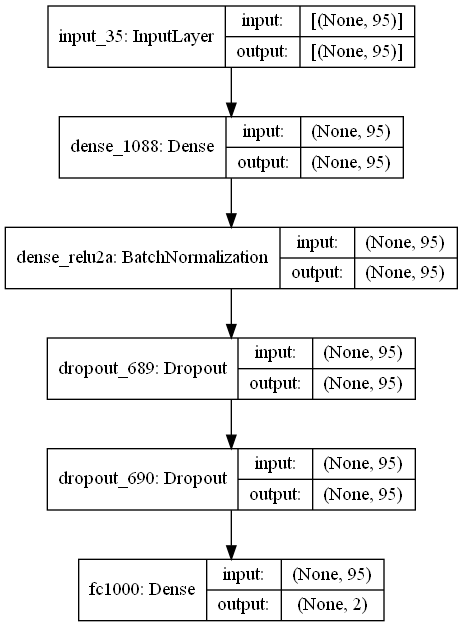

-0.4936412608207094
{'batch_norm': True, 'epochs': 10, 'n_out': 2}
[0 0 0 ... 0 0 0]


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [354]:

def keras_model_for_sklearn(optimizer='adam',#'adagrad',
                    loss = 'binary_crossentropy', 
                    kernel_initializer='glorot_uniform', 
                    dropout=0.2, n_in = 95,
                    n_activator = 'relu',
                    neurons = 213 ,
                    n_out = 2,
                    f_activator = 'softmax',
                    batch_norm = False,
                    metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]
                  ):
        
    
    input =tensorflow.keras.layers.Input(shape=(n_in,))

    output1 =tensorflow.keras.layers.Dense(n_in, input_shape=(n_in,), activation=n_activator)(input)
    if batch_norm:
        output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name='dense_relu' + '2a')(output1)
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)

    
    output1 =tensorflow.keras.layers.Dropout(dropout)(output1)
    output =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='fc1000')(output1)
    
    # Final model
    model =tensorflow.keras.models.Model(inputs=input, outputs=output)
    


    # Plot model information
    plot_= True
    plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
    if plot_:
        plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

import os

from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
# from sklearn.externals import joblib


# Load data
X_train = training_features
y_train =  training_targets

# Use Tenserflow backend
# sess = tf.Session()
# K.set_session(sess)


def model():
    model = models.Sequential([
        layers.Dense(64, input_dim=training_features.shape[1], activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64//2, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# feature_selection = SelectKBest(f_classif)
# pca = PCA() #performs better with PCA
# smote = SMOTE(sampling_strategy='minority', random_state=20)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')

# pipe = imbpipeline([#pipeline.Pipeline([
#     ('rescale', preprocessing.StandardScaler()),
#     ('selection', feature_selection),
#     ('pca', pca),
#     ('smote', smote),
#     ('nn', KerasClassifier(build_fn=model, nb_epoch=10, batch_size=64,
#                            validation_split=0.2
#                            , callbacks=[early_stopping]
#                            ))
# ])


##########
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred




model = KerasClassifier(build_fn = keras_model_for_sklearn, verbose=0)

param_grid = {
              'epochs':[20,10],
            #   'batch_size':[32,64,128],
            #   'optimizer' :           ['Adam', 'Nadam', 'adagrad'],
            #   'dropout' :        [0, 0.1, 0.2, 0.3],
            #   'n_activator' :          ['relu', 'elu', 'softmax'],
              'batch_norm' : [True, False],
              'n_out' : [2]
}


# Build a model architecture
target_train = np.asarray(training_targets).astype('float32').reshape((-1,1))
target_test = np.asarray(evaluation_targets).astype('float32').reshape((-1,1))#
input_n = len(training_features.columns)

# Preparing the results input/output, for evaluation later on
oh_enc = OneHotEncoder(sparse=False)
target_train_OH = oh_enc.fit_transform(target_train)
target_test_OH = oh_enc.transform(target_test)

model, pred = algorithm_pipeline(training_features.values, evaluation_features.values
# ,training_targets.values,  evaluation_targets
, target_train_OH , target_test_OH
, model, 
                                        param_grid, cv=5, scoring_fit='neg_log_loss')

print(model.best_score_)
print(model.best_params_)


# here begins hyper param optimization 


# parameters = {
#                   "selection__k": list(range(30, 90, 10))
#                 # , "ros__sampling_strategy": [0.05,0.1,0.2,0.3,0.4]
#                   , "selection__score_func": [chi2,f_classif]
#                   , "pca__n_components": [20,30,95]
#                 ,'smote__k_neighbors': [5,10,15]

#               }


# optimizer='adam',#'adagrad',
                    # loss = 'binary_crossentropy', 
                    # kernel_initializer='glorot_uniform', 
                    # dropout=0.2, n_in = 95,
                    # n_activator = 'relu',
                    # neurons = 213 ,
                    # n_out = 2,
                    # f_activator = 'softmax',
                    # batch_norm = False,
                    # metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]

# cv = StratifiedKFold(n_splits=HYPER_PARAMETER_OPTIMIZATION_CV, shuffle=True, random_state=RANDOM_SEED)

# grid_estimator = GridSearchCV(pipe
#                             , parameters
#                             , scoring=make_scorer(custom_scorer)#HYPER_PARAMETER_OPTIMIZATION_SCORING
#                             , cv=cv
#                             , verbose = 3 # Recomended to see the level 
#                             )

# grid_estimator.fit(training_features.values, training_targets.values)



# kc = KerasClassifier(build_fn=keras_model_for_sklearn, nb_epoch=10, batch_size=64
# # ,validation_split=0.2
#                            , callbacks=[early_stopping], verbose =3)
# gs = GridSearchCV(
#         estimator=kc,
#         param_grid=param_grid, 
#         cv=cv, 
#         n_jobs=-1, 
#         scoring=make_scorer(custom_scorer),
#         verbose=3
#     )
# fitted_model = gs.fit(training_features.values, training_targets.values)


# , clasification__eval_metric = metrics )
#############
# target_train_OH = oh_enc.fit_transform(target_train)
# target_test_OH = oh_enc.transform(target_test)

# pipe.fit(training_features.values
# # , target_train_OH)
# , training_targets.values)

# directory = os.path.dirname(os.path.realpath(__file__))
# model_step = pipe.steps.pop(-1)[1]
# joblib.dump(pipe, os.path.join(directory, 'pipeline.pkl'))
# models.save_model(model_step.model, os.path.join(directory, 'model.h5'))
##############################
def confusion_matrix_to_string(cm):
    return f"True operational={cm[0][0]}, True bankrupt={cm[1][1]}, False operational={cm[0][1]}, False bankrupt={cm[1][0]}"

def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


    
# Use all training data to calculate confusion matrix for training data
training_estimates = model.predict(training_features)
print(training_estimates)
# training_estimates = np.argmax(training_estimates,axis=1)
# target_train_OH , target_test_OH
training_accuracy = balanced_accuracy_score(target_train_OH, training_estimates)
training_confusion_matrix = confusion_matrix(target_train_OH, training_estimates)
training_confusion_matrix = confusion_matrix_to_string(training_confusion_matrix)


# Use model to estimate manually labeled evaluation Tweets
evaluation_estimates = model.predict(evaluation_features)
# evaluation_estimates = np.argmax(evaluation_estimates,axis=1)
evaluation_accuracy = balanced_accuracy_score(target_test_OH, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix(target_test_OH, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)

print(f"Balanced training. acc: {training_accuracy}")
print(f"Balanced eval. acc: {evaluation_accuracy}")

## Calculate metric values

In [ ]:
def confusion_matrix_to_string(cm):
    return f"True operational={cm[0][0]}, True bankrupt={cm[1][1]}, False operational={cm[0][1]}, False bankrupt={cm[1][0]}"

def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


    
# Use all training data to calculate confusion matrix for training data
training_estimates = estimator.predict(training_features)
# training_estimates = np.argmax(training_estimates,axis=1)

training_accuracy = balanced_accuracy_score(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix_to_string(training_confusion_matrix)


# Use model to estimate manually labeled evaluation Tweets
evaluation_estimates = estimator.predict(evaluation_features)
# evaluation_estimates = np.argmax(evaluation_estimates,axis=1)
evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)

print(f"Balanced training. acc: {training_accuracy}")
print(f"Balanced eval. acc: {evaluation_accuracy}")

110/110 [==============================] - 0s 1ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

## Visualisation of our results

In [ ]:
# Visualise the results
from sklearn.metrics import accuracy_score, f1_score

def print_model_acc(model, data_test, target_test, history):
    
    tensorflow.convert_to_tensor(data_test)
    data_test_reshape = np.asarray(data_test).astype('float32').reshape((-1,1))
    
    y_predictions = model.predict(data_test)
    predicted_classes = np.argmax(y_predictions,axis=1)
    np.set_printoptions(threshold=20)
    conf_matrix = confusion_matrix(target_test, predicted_classes)
    print('-- Model Specs --')
    print(f"  - Test Accuracy {accuracy_score(target_test, predicted_classes)} % ")
    print(f"  - RMSLE {RMSLE(target_test,predicted_classes)}  ")
    
    # Accuracy
    plt.subplot(1,2,1)
    
    plt.tight_layout()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Loss
    plt.subplot(1,2,2)
    
    plt.tight_layout()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


# , evaluation_features ,target_test, target_test_OH, training_features,target_train ,target_train_OH
print_model_acc(model, training_features, target_train, history)

from sklearn.metrics import confusion_matrix
def full_conf_mat(y_test, y_pred, data_title="Confusion Matrix of Training data"):
    
    print('-- Model Specs --')
    print(f"  - Test Accuracy {accuracy_score(y_test, y_pred)} % ")
    print(f"  - RMSLE {RMSLE(y_test,y_pred)}  ")

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)
    import seaborn as sns
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title(f'{data_title}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
full_conf_mat(training_targets, training_estimates, "Confusion Matrix of Training data")
full_conf_mat(evaluation_targets, evaluation_estimates, "Confusion Matrix of Validation/Evaluation data")


NameError: name 'history' is not defined

In [353]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer
print("Training evaluation")
y_pred_train = model.predict(training_features) #prediction on our train 
# y_pred_train = np.argmax(y_pred_train,axis=1)
print(classification_report(training_targets, y_pred_train))
train_conf_matrix = confusion_matrix(training_targets, y_pred_train)

print("Validation/evaluation")
y_pred_test = model.predict(evaluation_features) # prediction on our test set
# y_pred_test = np.argmax(y_pred_test,axis=1)
print(classification_report(evaluation_targets, y_pred_test))
test_conf_matrix = confusion_matrix(evaluation_targets, y_pred_test)


Training evaluation
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5279
           1       0.67      0.03      0.06       176

    accuracy                           0.97      5455
   macro avg       0.82      0.52      0.52      5455
weighted avg       0.96      0.97      0.95      5455

Validation/evaluation
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364



## Save trained model for future reference

-- Model Specs --
  - Test Accuracy 0.888359303391384 % 
  - RMSLE 0.23159902668521096  
[[4702  577]
 [  32  144]]


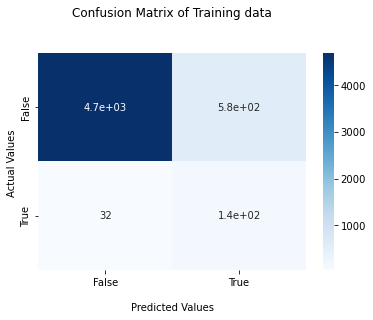

-- Model Specs --
  - Test Accuracy 0.8629032258064516 % 
  - RMSLE 0.2566487061330203  
[[1144  176]
 [  11   33]]


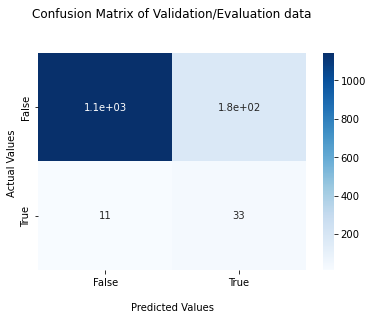

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_log_error

def RMSLE(y_true, y_pred):
    return numpy.sqrt(mean_squared_log_error(y_true, y_pred))

from sklearn.metrics import confusion_matrix
def full_conf_mat(y_test, y_pred, data_title="Confusion Matrix of Training data"):
    
    print('-- Model Specs --')
    print(f"  - Test Accuracy {accuracy_score(y_test, y_pred)} % ")
    print(f"  - RMSLE {RMSLE(y_test,y_pred)}  ")

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)
    import seaborn as sns
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title(f'{data_title}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
full_conf_mat(training_targets, training_estimates, "Confusion Matrix of Training data")

full_conf_mat(evaluation_targets, evaluation_estimates, "Confusion Matrix of Validation/Evaluation data")


In [ ]:
# with open(OUTPUT_MODEL, "wb") as handle:
#     pickle.dump(estimator, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Save metadata and calculated statistics
This is done by saving every textual and numerical variable to file.

In [ ]:
current_variables = dir()

results_string = ""

for variable in current_variables:
    # Skip environment variables and their container variable
    # Ignore also underscore variables
    if variable in environment_variables or variable == "environment_variables" or variable.startswith("_"):
        continue

    # Get variables value
    variable_value = globals()[variable]

    # If variable is numerical or string, append it to results
    if type(variable_value) is str or type(variable_value) is int or \
        type(variable_value) is float or type(variable_value) is list or \
        type(variable_value) is numpy.float64 or type(variable_value) is dict:
        results_string += f"{variable}: {variable_value}\n"

# Print results to screen
print(results_string)

# Save results to file
with open(OUTPUT_RESULTS, "w") as file:
    file.write(results_string)

CROSS_VALIDATION_CV: 5
EVALUATION_FILES: ['../data/original/evaluation_dataset.csv', '..\\data\\preprocessed\\difference_preprocessed_evaluation_dataset.csv', '..\\data\\preprocessed\\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv']
FILE_N: 0
HYPER_PARAMETER_ALPHA: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]
HYPER_PARAMETER_HIDDEN_LAYER_SIZES: [(100,)]
HYPER_PARAMETER_K_FEATURES: [30, 40, 50, 60, 70, 80]
HYPER_PARAMETER_OPTIMIZATION_BETA: 2
HYPER_PARAMETER_OPTIMIZATION_CV: 5
HYPER_PARAMETER_OPTIMIZATION_SCORING: accuracy
HYPER_PARAMETER_SCORE_FUNC: [<function chi2 at 0x000002C597AF41F0>, <function f_classif at 0x000002C597AF40D0>]
INPUT_EVALUATION_FILE: ../data/original/evaluation_dataset.csv
INPUT_TRAINING_FILE: ../data/original/training_dataset.csv
LABELS: ['Operational', 'Bankrupt']
METHOD_NAME: keras_tensorflow_resnet
OUTPUT_MODEL: ../data/models/keras_tensorflow_resnet_model_12_05_2022-19_05_15.pkl
OUTPUT_MODEL_ARCHITECTURE_RESULTS: ../img/keras_tensorflow_resnet_mo